In [1]:
import numpy as np
from interpolation import interp
from numba import njit
import matplotlib.pyplot as plt
%matplotlib inline
from quantecon import MarkovChain
from scipy.optimize import minimize_scalar

from numba import njit, jit, jitclass, float64, prange
from quantecon.optimize import brent_max

### Set-Up

Consider a household that chooses a state-contingent consumption plan $ \{c_t\}_{t \geq 0} $ to maximize

$$
\mathbb{E} \, \sum_{t=0}^{\infty} \beta^t u(c_t)
$$

subject to


<a id='equation-eqst'></a>
$$
a_{t+1} \leq  R(a_t-c_t)  + z_{t+1},
\qquad c_t \geq 0,
\qquad a_t \geq -b
\qquad t = 0, 1, \ldots \tag{1}
$$

Note: above diverges in timing from current model in ifp. 

Here

- $ \beta \in (0,1) $ is the discount factor  
- $ a_t $ is asset holdings at time $ t $, with ad-hoc borrowing constraint $ a_t \geq -b $  
- $ c_t $ is consumption  
- $ z_t $ is non-capital income (wages, unemployment compensation, etc.)  
- $ R := 1 + r $, where $ r > 0 $ is the interest rate on savings  


Non-capital income $ \{z_t\} $ is assumed to be a Markov process taking values in $ Z\subset (0,\infty) $ with stochastic kernel $ \Pi $.

This means that $ \Pi(z, B) $ is the probability that $ z_{t+1} \in
B $ given $ z_t = z $.

The expectation of $ f(z_{t+1}) $ given $ z_t = z $ is written as

$$
\int f( \acute z) \, \Pi(z, d \acute z)
$$

We further assume that

1. $ r > 0 $ and $ \beta R < 1 $  
1. $ u $ is smooth, strictly increasing and strictly concave with $ \lim_{c \to 0} u'(c) = \infty $ and $ \lim_{c \to \infty} u'(c) = 0 $  


The asset space is $ [-b, \infty) $ and the state is the pair $ (a,z) \in S := [-b,\infty) \times Z $.

A *feasible consumption path* from $ (a,z) \in S $ is a consumption
sequence $ \{c_t\} $ such that $ \{c_t\} $ and its induced asset path $ \{a_t\} $ satisfy

1. $ (a_0, z_0) = (a, z) $  
1. the feasibility constraints in [(1)](ifp_advanced.ipynb#equation-eqst), and  
1. measurability of $ c_t $ w.r.t. the filtration generated by $ \{z_1, \ldots, z_t\} $  


The meaning of the third point is just that consumption at time $ t $ can only be
a function of outcomes that have already been observed.

### Value Function Iteration

The Bellman operator for this problem is given by


<a id='equation-eqbop'></a>
$$
Tv(a, z)
= \max_{0 \leq c \leq a }
\left\{
    u(c) + \beta \int v(R(a-c) + \acute z , \acute z) \Pi(z, d \acute z)
\right\} \tag{10}
$$

We have to be careful with VFI (i.e., iterating with
$ T $) in this setting because $ u $ is not assumed to be bounded

- In fact typically unbounded both above and below — e.g. $ u(c) = \log c $.  
- In which case, the standard DP theory does not apply.  
- $ T^n v $ is not guaranteed to converge to the value function for arbitrary continuous bounded $ v $.  



The latter is known to converge, as described above.

## Implementation


We're going to create a ``@jitclass`` called ``ConsumerProblem`` to hold our primitives and return the right hand side of the bellman equation.

In [2]:
consumer_data = [
    ('r', float64),              # rate of interest
    ('β', float64),              # discount factor
    ('Π', float64[:,:]),         # Markov matrix for z_t
    ('z_vals', float64[:]),      # State space of z_t
    ('b', float64),              # Borrowing constraint
    ('asset_grid', float64[:]),  # the finite grid
    ('R', float64)               # return of asset
]

In [3]:
@jitclass(consumer_data)
class ConsumerProblem:
    """
    A class that stores primitives for the income fluctuation problem. The
    income process is assumed to be a finite state Markov chain.
    """
    def __init__(self,
                 r=0.01,                        # Interest rate
                 β=0.96,                        # Discount factor
                 Π=((0.6, 0.4),
                    (0.05, 0.95)),              # Markov matrix for z_t
                 z_vals=(0.5, 1.0),             # State space of z_t
                 b=1e-04,                       # Borrowing constraint
                 grid_max=16,                   #intial asset 
                 grid_size=1000                 #discrete grid size
                 ):
        self.r, self.R = r, 1 + r
        self.β, self.b = β, b
        self.Π, self.z_vals = np.array(Π), np.array(z_vals)
        self.asset_grid = np.linspace(b, grid_max, grid_size)
        
    def u(self, c):
        # returns utility function
        return np.log(c)

    def state_action_value(self, c, a, i_z, v):
        
        # Will return RHS of bellman equation
        
        β, u, R = self.β, self.u, self.R
        
        z_vals, asset_grid, Π = self.z_vals, self.asset_grid, self.Π
        
        expectation = 0
        vf = lambda x: interp(asset_grid, v[:,i_z], x)
        
        for j in range(len(z_vals)):
            expectation += vf(R * (a - c) + z_vals[j]) * Π[i_z, j]

        return u(c) + β * expectation

We'll hold this class in an instant called ``cp``.

In [4]:
cp = ConsumerProblem()

How we'll create the bellman operator function ``T`` to return our updated value function.

In [5]:
@njit
def T(cp, v):

    v_new = np.empty_like(v)
    
    for i_z in prange(len(cp.z_vals)):
        for i_a in range(len(cp.asset_grid)):
            a = cp.asset_grid[i_a]
        
            v_new[i_a, i_z] = brent_max(cp.state_action_value, 1e-11,  a, args=(a, i_z, v))[1]

    return v_new

Now we create a function call ``value_function`` which will iterate through the bellman operator and return the converged value function.

In [6]:
def value_function(cp,
                tol=1e-4,
                max_iter=1000,
                verbose=True,
                print_skip=25):

    """
    Solves for the optimal policy using time iteration

    * cp is an instance of ConsumerProblem
    """

    u, β, b, R = cp.u, cp.β, cp.b, cp.R
    asset_grid, z_vals = cp.asset_grid, cp.z_vals

    # Initial guess of v
    v = np.empty((len(asset_grid), len(z_vals)))    
    for z in (0,1):
        v[:,z] = cp.u(asset_grid)
    
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = T(cp, v)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print("Error at iteration {} is {}.".format(i, error))
        v = v_new
        

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print("\nConverged in {} iterations.".format(i))
        

    return v

In [7]:
v_star = value_function(cp)

Error at iteration 25 is 0.13652345850703185.
Error at iteration 50 is 0.049201347538097906.
Error at iteration 75 is 0.017732003880858827.
Error at iteration 100 is 0.006390556068929243.
Error at iteration 125 is 0.0023031355588614133.
Error at iteration 150 is 0.0008300424414509067.
Error at iteration 175 is 0.00029914458242252806.
Error at iteration 200 is 0.0001078107345779955.

Converged in 202 iterations.


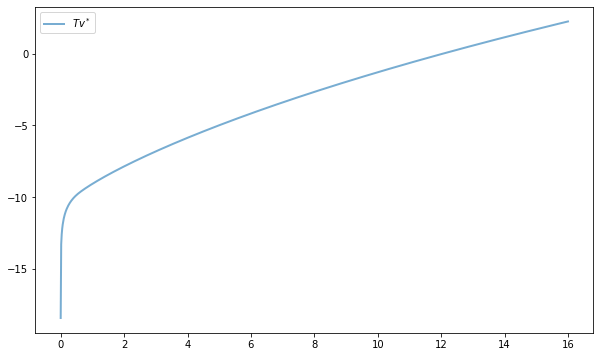

In [8]:
grid = cp.asset_grid

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(grid, v_star[:,0], lw=2, alpha=0.6, label='$Tv^*$')
ax.legend()
plt.show()

## Check Policy function

``σ`` returns the policy function for the converged value function, we will check it is the same as the current outputed policy function in ifp. (I note this model has differences to the current ifp)

In [9]:
@njit
def σ(cp, v):

    c_new = np.empty_like(v)
    for i_z in prange(len(cp.z_vals)):
        for i_a in range(len(cp.asset_grid)):
            a = cp.asset_grid[i_a]
            c_new[i_a, i_z] = brent_max(cp.state_action_value, 1e-11,  a, args=(a, i_z, v))[0]

    return c_new

In [10]:
c_star = σ(cp, v_star)

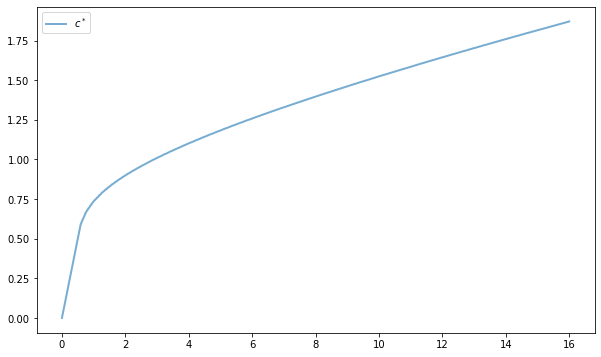

In [11]:
grid = cp.asset_grid

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(grid, c_star[:,0], lw=2, alpha=0.6, label='$c^*$')
ax.legend()
plt.show()